In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import csv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Make sure you have a folder named "mnist" and it contains "mnist_test.csv" and "mnist_train.csv" from

https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/

In [2]:
# Loading the MNIST dataset csv into a torch dataset class
# Lets you use dataloader
class MNISTCSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = []
        self.labels = []
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                label = int(row[0])
                pixels = np.array(row[1:], dtype=np.float32) / 255.0  # normalize
                self.data.append(pixels)
                self.labels.append(label)

        self.data = np.array(self.data).reshape(-1, 1, 28, 28)  # reshape

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx])
        return x, y
    
trainingSet = MNISTCSVDataset('mnist/mnist_train.csv')
testingSet = MNISTCSVDataset('mnist/mnist_test.csv')

Training Set size: 60000
Testing Set size: 10000


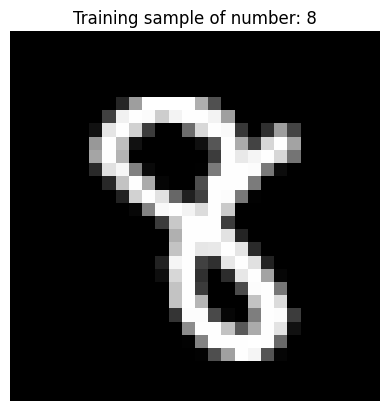

In [27]:
print(f"Training Set size: {len(trainingSet)}")
print(f"Testing Set size: {len(testingSet)}")
# print(trainingSet[0][0])
# Also get a random image for preview
random_idx = random.randint(0, len(trainingSet) -1)
image, label = trainingSet[random_idx]
image = image.squeeze()
plt.imshow(image, cmap='gray')
plt.title(f"Training sample of number: {label}")
plt.axis('off')
plt.show()

In [29]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0)  # 8x26x26 No padding, stride=1
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8 * 26 * 26, 10)  # 28x28 input → 26x26 conv output

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def train_model(model: nn.Module, loader, epochs=5):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train() # Set to train mode
    for epoch in range(epochs):
        all_preds = []
        all_targets = []
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        acc = 100 * np.mean(np.array(all_preds) == np.array(all_targets))
        f1 = f1_score(all_targets, all_preds, average='macro')
        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc:.2f}%, F1 Score: {f1:.4f}, Loss: {loss.item():.4f}")


In [30]:
weightsFolder = 'weights'
def export_weights(model):
    state = model.state_dict()
    conv_w = state['conv.weight'].cpu().numpy()  # shape (8,1,3,3)
    conv_b = state['conv.bias'].cpu().numpy()    # shape (8,)
    fc_w   = state['fc.weight'].cpu().numpy()    # shape (10,5408)
    fc_b   = state['fc.bias'].cpu().numpy()      # shape (10,)

    np.save(f"{weightsFolder}/conv_weight.npy", conv_w)
    np.save(f"{weightsFolder}/conv_bias.npy", conv_b)
    np.save(f"{weightsFolder}/fc_weight.npy", fc_w)
    np.save(f"{weightsFolder}/fc_bias.npy", fc_b)
    print("Weights exported as .npy files.")
    
def save_as_c_array(npy_file, var_name, output_file):
    arr = np.load(f"{weightsFolder}/{npy_file}")
    flat = arr.flatten()

    with open(f"{weightsFolder}/{output_file}", "w") as f:
        f.write(f"// {arr.shape}\n")
        f.write(f"float {var_name}[{len(flat)}] = {{\n")
        for i, val in enumerate(flat):
            f.write(f"{val}f, ")
            if (i + 1) % 8 == 0:
                f.write("\n")
        f.write("};\n")
        


# DON'T RUN THIS UNLESS U WANT TO RETRAIN MODEL

In [18]:
dataloader = DataLoader(trainingSet, batch_size=64, shuffle=True)

model = cnn().to(device) # Move to GPU if possible
train_model(model, dataloader, epochs=25)

Epoch 1/25, Accuracy: 91.67%, F1 Score: 0.9159, Loss: 0.1240
Epoch 2/25, Accuracy: 96.66%, F1 Score: 0.9665, Loss: 0.0200
Epoch 3/25, Accuracy: 97.64%, F1 Score: 0.9763, Loss: 0.0305
Epoch 4/25, Accuracy: 98.05%, F1 Score: 0.9804, Loss: 0.0349
Epoch 5/25, Accuracy: 98.31%, F1 Score: 0.9831, Loss: 0.1221
Epoch 6/25, Accuracy: 98.53%, F1 Score: 0.9853, Loss: 0.0146
Epoch 7/25, Accuracy: 98.75%, F1 Score: 0.9874, Loss: 0.0302
Epoch 8/25, Accuracy: 98.91%, F1 Score: 0.9890, Loss: 0.0893
Epoch 9/25, Accuracy: 99.05%, F1 Score: 0.9905, Loss: 0.0179
Epoch 10/25, Accuracy: 99.13%, F1 Score: 0.9913, Loss: 0.0802
Epoch 11/25, Accuracy: 99.24%, F1 Score: 0.9924, Loss: 0.0082
Epoch 12/25, Accuracy: 99.36%, F1 Score: 0.9936, Loss: 0.0074
Epoch 13/25, Accuracy: 99.43%, F1 Score: 0.9943, Loss: 0.0023
Epoch 14/25, Accuracy: 99.49%, F1 Score: 0.9949, Loss: 0.0075
Epoch 15/25, Accuracy: 99.57%, F1 Score: 0.9957, Loss: 0.0052
Epoch 16/25, Accuracy: 99.63%, F1 Score: 0.9963, Loss: 0.0082
Epoch 17/25, Accu

In [22]:
export_weights(model)

Weights exported as .npy files.


In [23]:
torch.save(model, "weights/model_weights.pth")
save_as_c_array("conv_weight.npy", "conv_weights", "conv_weights.h")
save_as_c_array("conv_bias.npy", "conv_biases", "conv_biases.h")
save_as_c_array("fc_weight.npy", "fc_weights", "fc_weights.h")
save_as_c_array("fc_bias.npy", "fc_biases", "fc_biases.h")

In [31]:
# Testing on the test data set
model = torch.load("weights/model_weights.pth").to(device)
model.eval()
trainLoader = DataLoader(testingSet, batch_size=64, shuffle=False)

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():  # disable gradient tracking
    for inputs, labels in trainLoader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        preds = probabilities.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test set evaluation: Accuracy = {correct}/{total} {accuracy:.2f}%, F1 Score = {f1:.4f}")

C:\Users\61435\AppData\Local\Temp\ipykernel_35152\230626830.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("weights/model_weights.pth").to(device)


Test set evaluation: Accuracy = 9782/10000 97.82%, F1 Score = 0.9780


In [25]:
# Examining model weights and biases
state = model.state_dict()
conv_w = state['conv.weight'].cpu().numpy()  # shape (8,1,3,3)
conv_b = state['conv.bias'].cpu().numpy()    # shape (8,)
fc_w   = state['fc.weight'].cpu().numpy()    # shape (10,5408)
fc_b   = state['fc.bias'].cpu().numpy()      # shape (10,)

print(conv_b)

[-0.15180436 -0.79033625 -0.1798562   0.00154718 -0.2145303  -0.07125219
 -0.01330574  0.13734898]
